In [15]:
import numpy as np
import matplotlib.pylab as plt
import blimpy as bl
%matplotlib inline

In [16]:
from typing import List, Tuple

from astropy.time import Time
from astropy import units as u

In [17]:
MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot


def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)")
    if MJD_time:
        plt.ylabel("Time (MJD)")
    else:
        plt.ylabel("Time (s)")

#    print('this is plot_data:', plot_data)
#    print('this is plot_data\'s shape:', plot_data.shape)
#    print('this is plot_f:', plot_f)
#    print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 2, (2 * i) + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [18]:
def make_waterfall_plots_full(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                              line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 1, i + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

##        if i == 0:
##            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [19]:
TELESCOPE = 'GBT'
OBS_TIME = '300s x 3'

In [20]:
all_targets = []

f = open('result_2_filenames.txt', 'r')
text = f.read().split()
f.close()

for word in text:
    if 'directory' not in word and '.csv' in word:
        all_targets.append(word[:-4])

all_targets = []

f = open('result_2_filenames.txt', 'r')
text = f.read().split()
f.close()

for word in text:
    if 'directory' not in word and '.csv' in word:
        if '_0' in word:
            all_targets.append(word[:-6])
        else:
            all_targets.append(word[:-4])

In [21]:
all_targets

['GJ1002_0',
 'GJ273_0',
 'GJ380_0',
 'GJ406_0',
 'GJ411_0',
 'GJ447_0',
 'GJ473AB_0',
 'GJ702A_0',
 'GJ702B_0',
 'GJ860A_0',
 'GJ860B_0',
 'HIP100064_0',
 'HIP100511_0',
 'HIP101955_0',
 'HIP102040_0',
 'HIP102226_0',
 'HIP102488',
 'HIP102531_0',
 'HIP102532_0',
 'HIP102766_0',
 'HIP103256_0',
 'HIP103388_0',
 'HIP103441_0',
 'HIP10416_0',
 'HIP105668_0',
 'HIP105860_0',
 'HIP105932_0',
 'HIP106106_0',
 'HIP10644_0',
 'HIP10670_0',
 'HIP11000_0',
 'HIP11029_0',
 'HIP110750',
 'HIP111169_0',
 'HIP111170',
 'HIP111888',
 'HIP112190',
 'HIP112245_0',
 'HIP112724_0',
 'HIP112909_0',
 'HIP112915_0',
 'HIP113409_0',
 'HIP113421_0',
 'HIP113718_0',
 'HIP114233_0',
 'HIP114456_0',
 'HIP114570_0',
 'HIP114886_0',
 'HIP115142_0',
 'HIP115445_0',
 'HIP11569',
 'HIP115738_0',
 'HIP116106',
 'HIP116384',
 'HIP116495',
 'HIP116758',
 'HIP120005_0',
 'HIP12158_0',
 'HIP12493_0',
 'HIP12530_0',
 'HIP13081_0',
 'HIP13402_0',
 'HIP13642_0',
 'HIP13665_0',
 'HIP13834_0',
 'HIP14150_0',
 'HIP14293_0',
 

In [22]:
print(len(all_targets))

203


In [23]:
def get_cadence(target_name: str) -> List[str]:
    
    cadence = []
    
    if '_0' in target_name:
        filename = 'result_2/' + target_name[:-2] + '_directory_5.csv'
    else:
        filename = 'result_2/' + target_name + '_directory.csv'
        
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        h5file = info[1][12:]
        cadence.append(h5file)
    
    return cadence

In [24]:
def get_hits(target_name: str) -> List[List[float]]:
    
    hits = []

    filename = 'result_2/' + target_name + '.csv'
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        start = float(info[1])
        stop = float(info[2])
        fit = float(info[3])
        hits.append([start, stop, fit])

    return hits

In [25]:
class Target:
    
    
    def __init__(self, target_name: str) -> None:
        
        if '_0' in target_name:
            name = target_name[:-2]
        else:
            name = target_name
        
        self.name = name
        self.cadence = get_cadence(target_name)
        self.hits = get_hits(target_name)
        self.num_hits = len(self.hits)
    
    def __str__(self) -> str:
        
        if self.num_hits == 1:
            return 'Target {} with {} hit'.format(self.name, self.num_hits)
        
        return 'Target {} with {} hits'.format(self.name, self.num_hits)
    
    
    def get_cadence_type(self) -> str:
        
        if len(self.cadence) == 6:
        
            lst = []

            for i in range(len(self.cadence)):
                fb = bl.Waterfall(self.cadence[i], load_data=False)
                source = fb.header['source_name']
                lst.append(source)

            if lst[0] == lst[2] == lst[4]:
                
                if lst[1] == lst[3] == lst[5] \
                and lst[0] != lst[1]:
                    return 'ABABAB'
                          
                elif lst[1] != lst[3] and lst[1] != lst[5] and lst[3] != lst[5] \
                and lst[0] != lst[1] and lst[0] != lst[3] and lst[0] != lst[5]:
                    return 'ABACAD'
        
        return 'other'
    
    
    def get_RA(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        RA = fb.header['src_raj']
        
        return str(RA)
    
    
    def get_DEC(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        DEC = fb.header['src_dej']
        
        return str(DEC)
    
    
    def get_date_time(self, ISOT=True) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        mjd = fb.header['tstart']
        
        if ISOT:
            return Time(mjd, format='mjd').isot
        
        return str(mjd)
    
    
    def get_min_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            min_freq = fb.container.f_start - fb.header['foff']
        else:
            min_freq = fb.container.f_start
        
        return str(min_freq) + ' MHz'
    

    def get_max_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            max_freq = fb.container.f_stop

        else:
            max_freq = fb.container.f_stop - fb.header['foff']
        
        return str(max_freq) + ' MHz'

In [26]:
COLUMN = 52

In [27]:
class Hit:
    
    
    def __init__(self, target: Target, index: int) -> None:
        
        self.target = target
        self.target_name = target.name
        self.number = index + 1
        self.start_freq = target.hits[index][0]
        self.end_freq = target.hits[index][1]
        self.fit = target.hits[index][2]
    
    def __str__(self) -> str:
        
        return 'Hit {} of {} for target {}'.format(self.number, self.target.num_hits, self.target_name)
    
    
    def make_plot(self):
        
        plt.rc('font', size=10)
        
        mid_freqs_pink = []
        fits_pink = []
        
        for i in range(self.target.num_hits):

            mid_freq = (self.target.hits[i][0] + self.target.hits[i][1]) / 2
            fit = self.target.hits[i][2]
            
            mid_freqs_pink.append(mid_freq)
            fits_pink.append(fit)
        
        marker_size = 4 / (self.target.num_hits / 5000)
        
        plt.scatter(mid_freqs_pink, fits_pink, color='pink', marker='.', s=marker_size)
        
        mid = (self.start_freq + self.end_freq) / 2
        plt.plot(mid, self.fit, marker='o', color='red', ms=8)
        
        plot_start = float(self.target.get_min_freq()[:-4])
        plot_end = float(self.target.get_max_freq()[:-4])
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Fit')
        plt.title('Position of hit in the frequency band')
        
    
    def get_ID(self, targets_list: List[str]) -> str:
        
        if self.target_name in targets_list:
            first = str(targets_list.index(self.target_name) + 1)
        else:
            first = str(targets_list.index(self.target_name + '_0') + 1)
            
        second = str(self.number)
        
        ID = first.rjust(3, '0') + '-' + second.rjust(5, '0')
        
        return ID
        

    def print_info(self, targets_list) -> None:
        
        s1 = 'Target name: ' + self.target_name
        s2 = 'Number of hits for this target: ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Right ascension: ' + self.target.get_RA()
        s2 = 'Average number of hits per target: ' + str(avg_num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Declination: ' + self.target.get_DEC()
        print(s1)

        s1 = 'Telescope: ' + TELESCOPE
        print(s1)

        s1 = 'Observation start (MJD): ' + self.target.get_date_time(ISOT=False)
        s2 = '\t\tHit #' + str(self.number) + ' of ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Observation start (ISOT): ' + self.target.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Cadence: ' + self.target.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Min frequency: ' + self.target.get_min_freq()
        s2 = 'Probability: ' + str(self.fit * 100) + '%'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Max frequency: ' + self.target.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(targets_list)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

In [28]:
num_hits_per_target = []

for target_name in all_targets:
    n = Target(target_name).num_hits
    num_hits_per_target.append(n)

avg_num_hits = np.sum(num_hits_per_target) / len(all_targets)

In [29]:
tab = ' ' * (14 - len('Target index'))

print('Target index', tab, 'Number of hits')

for i, num in enumerate(num_hits_per_target):
    tab = ' ' * (14 - len(str(i)))
    print(i, tab, num)

Target index    Number of hits
0               3306
1               14514
2               13101
3               14756
4               13742
5               15701
6               13745
7               11991
8               11972
9               13690
10              12864
11              6115
12              13064
13              11244
14              12941
15              14375
16              12804
17              4264
18              4486
19              11879
20              13538
21              828
22              14293
23              2206
24              2000
25              13938
26              5868
27              14181
28              9837
29              2025
30              2914
31              2275
32              3303
33              5635
34              520
35              11573
36              15044
37              14791
38              16022
39              14424
40              14790
41              1310
42              13558
43              14931
44              137

In [30]:
np.max(num_hits_per_target)

17324

In [40]:
def plot_highlighted_hist(target: Target):

    plt.rc('font', size=10)
    
    binning = np.arange(0, 18000, 500)

    array, bins, patches = plt.hist(num_hits_per_target, bins=binning, color='gray')

    n = target.num_hits // 500
    patches[n].set_fc('red')
    
#    plt.yticks(ticks=[0, 1, 2, 3, 4])

    plt.grid()
    plt.xlabel('Number of hits')
    plt.ylabel('Number of targets')
    plt.title('Hits per target')

In [32]:
# To pick a target, redefine i or directly define target as the corresponding string:
i = 1
target = Target(all_targets[i])

In [33]:
target.num_hits

14514

In [34]:
tab = ' ' * (10 - len('Hit index'))
j_list = []

print('Hit index', tab, 'Probability')
for j in range(len(target.hits)):
    if target.hits[j][2] > 0.99:
        tab = ' ' * (10 - len(str(j)))
        j_list.append(j)
        print(j, tab, target.hits[j][2])
print('\nlen =', len(j_list))

Hit index   Probability
334         1.0
478         1.0
649         0.993
982         0.995
1186        0.995
1451        0.998
1553        0.998
1614        0.995
1797        0.994
1839        0.999
1971        0.993
2020        0.999
2041        0.998
2155        0.999
2413        1.0
2692        1.0
2737        0.995
2738        1.0
2990        0.996
3225        0.997
3463        0.999
3551        1.0
3943        0.998
4039        0.997
4073        0.998
4143        0.994
4488        0.999
4674        0.992
4700        0.994
4704        0.995
4745        0.999
5104        0.998
5124        1.0
5145        0.998
5158        0.992
5583        0.999
5660        0.995
6036        0.994
6050        0.998
6665        0.993
7054        0.995
7096        1.0
7108        0.999
7138        0.991
7323        0.997
7402        1.0
7674        0.997
7828        0.998
7847        0.993
8063        0.992
8145        0.991
8241        0.992
8488        0.996
8669        0.994
8943        0.995
9066

In [35]:
k = 0

# To pick a hit, redefine j
j = j_list[k]
hit = Hit(target, j)

for j in range(len(target.hits)):
    if target.hits[j][2] > 0.99:
        hit = Hit(target, j)

        ID = hit.get_ID(all_targets)
        start = hit.start_freq
        stop = hit.end_freq
        mid = (start + stop) / 2

        #make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                                  f_start=start, f_stop=stop, correction_in=mid)

        #plt.suptitle('Candidate ' + ID)
        #plt.gcf().set_size_inches(12, 6)    
#        plt.savefig('waterfall_plots/candidate-' + ID)

for target_name in all_targets[10:]:
    target = Target(target_name)
    
    for j in range(len(target.hits)):
        if target.hits[j][2] > 0.99:
            hit = Hit(target, j)
        
            ID = hit.get_ID(all_targets)
            start = hit.start_freq
            stop = hit.end_freq
            mid = (start + stop) / 2

            make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                                      f_start=start, f_stop=stop, correction_in=mid)

            plt.suptitle('Candidate ' + ID)
            plt.gcf().set_size_inches(12, 6)    
            plt.savefig('waterfall_plots/candidate-' + ID)

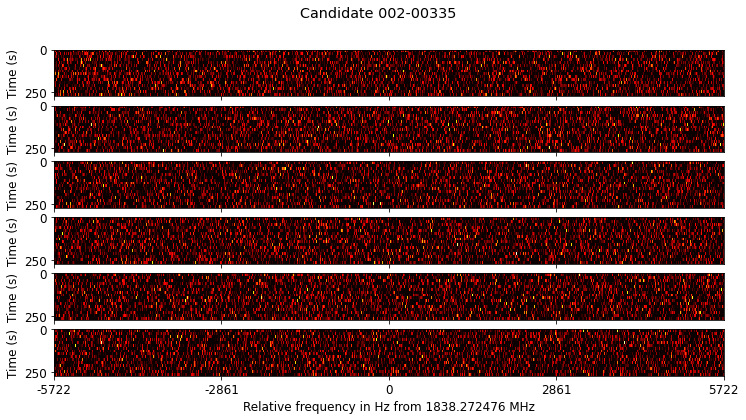

In [36]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(12, 6)  
plt.show()

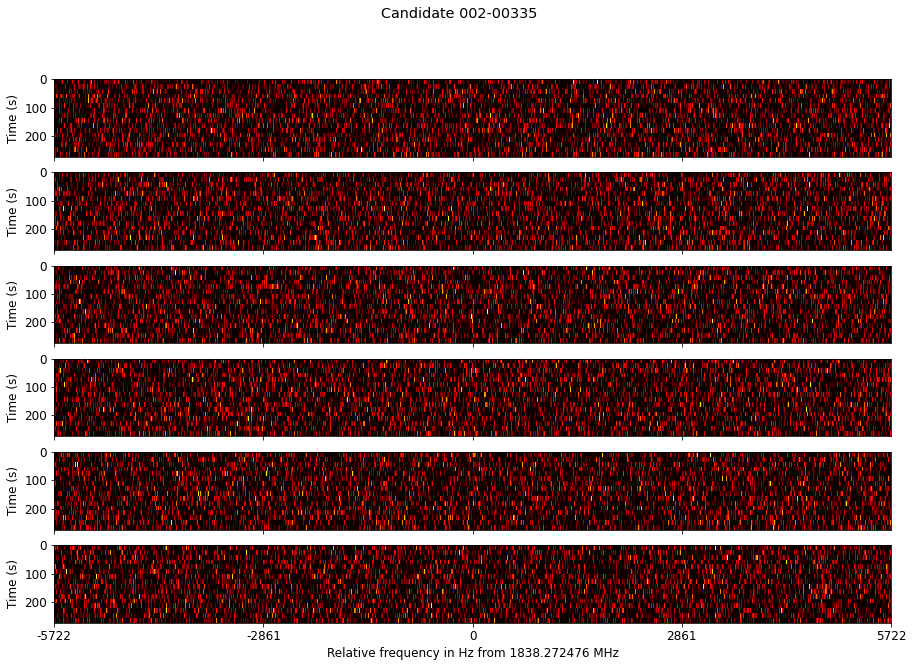

In [37]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [38]:
target = Target(all_targets[8])
hit = Hit(target, 61)

					Candidate information

Target name: GJ702B                                   Number of hits for this target: 11972
Right ascension: 18h05m27.3784s                       Average number of hits per target: 9678.374384236453
Declination: 2d29m43.9998s
Telescope: GBT
Observation start (MJD): 57690.90421296296            		Hit #62 of 11972
Observation start (ISOT): 2016-10-29T21:42:04.000     Start frequency: 1869.9783325195312 MHz
Observing time: 300s x 3                              End frequency: 1869.9897766113281 MHz
Cadence: ABACAD                                       Event bandwidth: 11444.091796875 Hz
Min frequency: 1818.4570340439677 MHz                 Probability: 56.699999999999996%
Max frequency: 2720.80078125 MHz                      Candidate ID: 009-00062


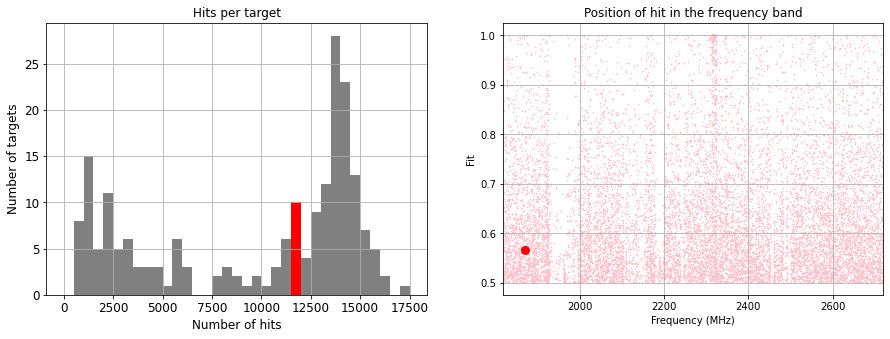

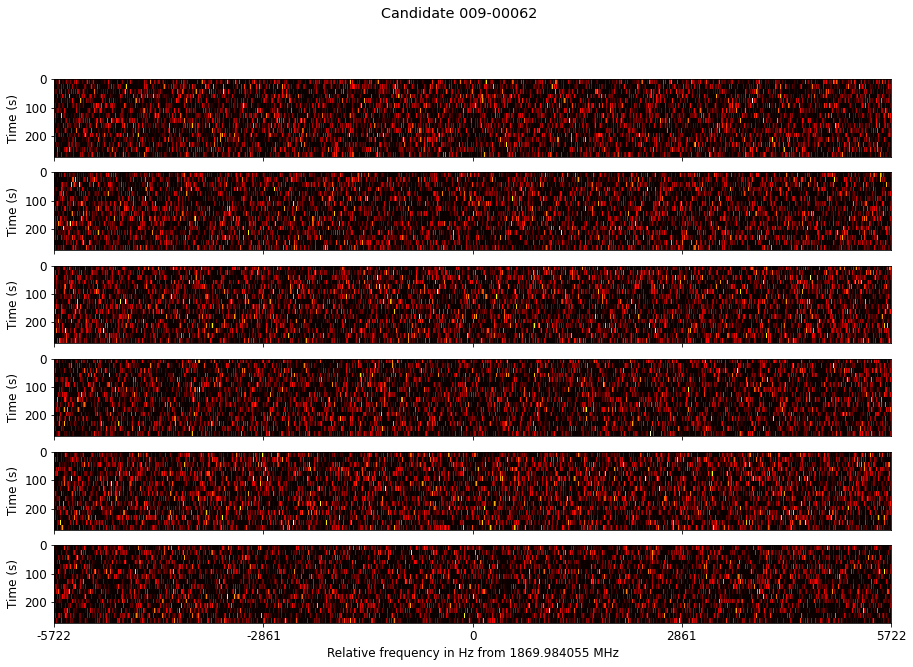

In [41]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(1, 2, 2)
hit.make_plot()

plt.gcf().set_size_inches(15, 5)    
plt.show()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff

make_waterfall_plots(filenames_list=target.cadence, target=target.name, f_start=start, f_stop=stop)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info()

plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff

make_waterfall_plots(filenames_list=target.cadence, target=target.name, f_start=start, f_stop=stop)

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
plt.subplot(2, 2, 1)
hit.print_info()

plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()


start = hit.start_freq
stop = hit.end_freq
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)

In [ ]:
bl.Waterfall(target.cadence[0], f_start=hit.start_freq, f_stop=hit.end_freq)

In [ ]:
help(bl.Waterfall)

À faire:

- Remove space and ticks
- x-axis label
- Add two lines that delimit event
- Add and adjust colorbar